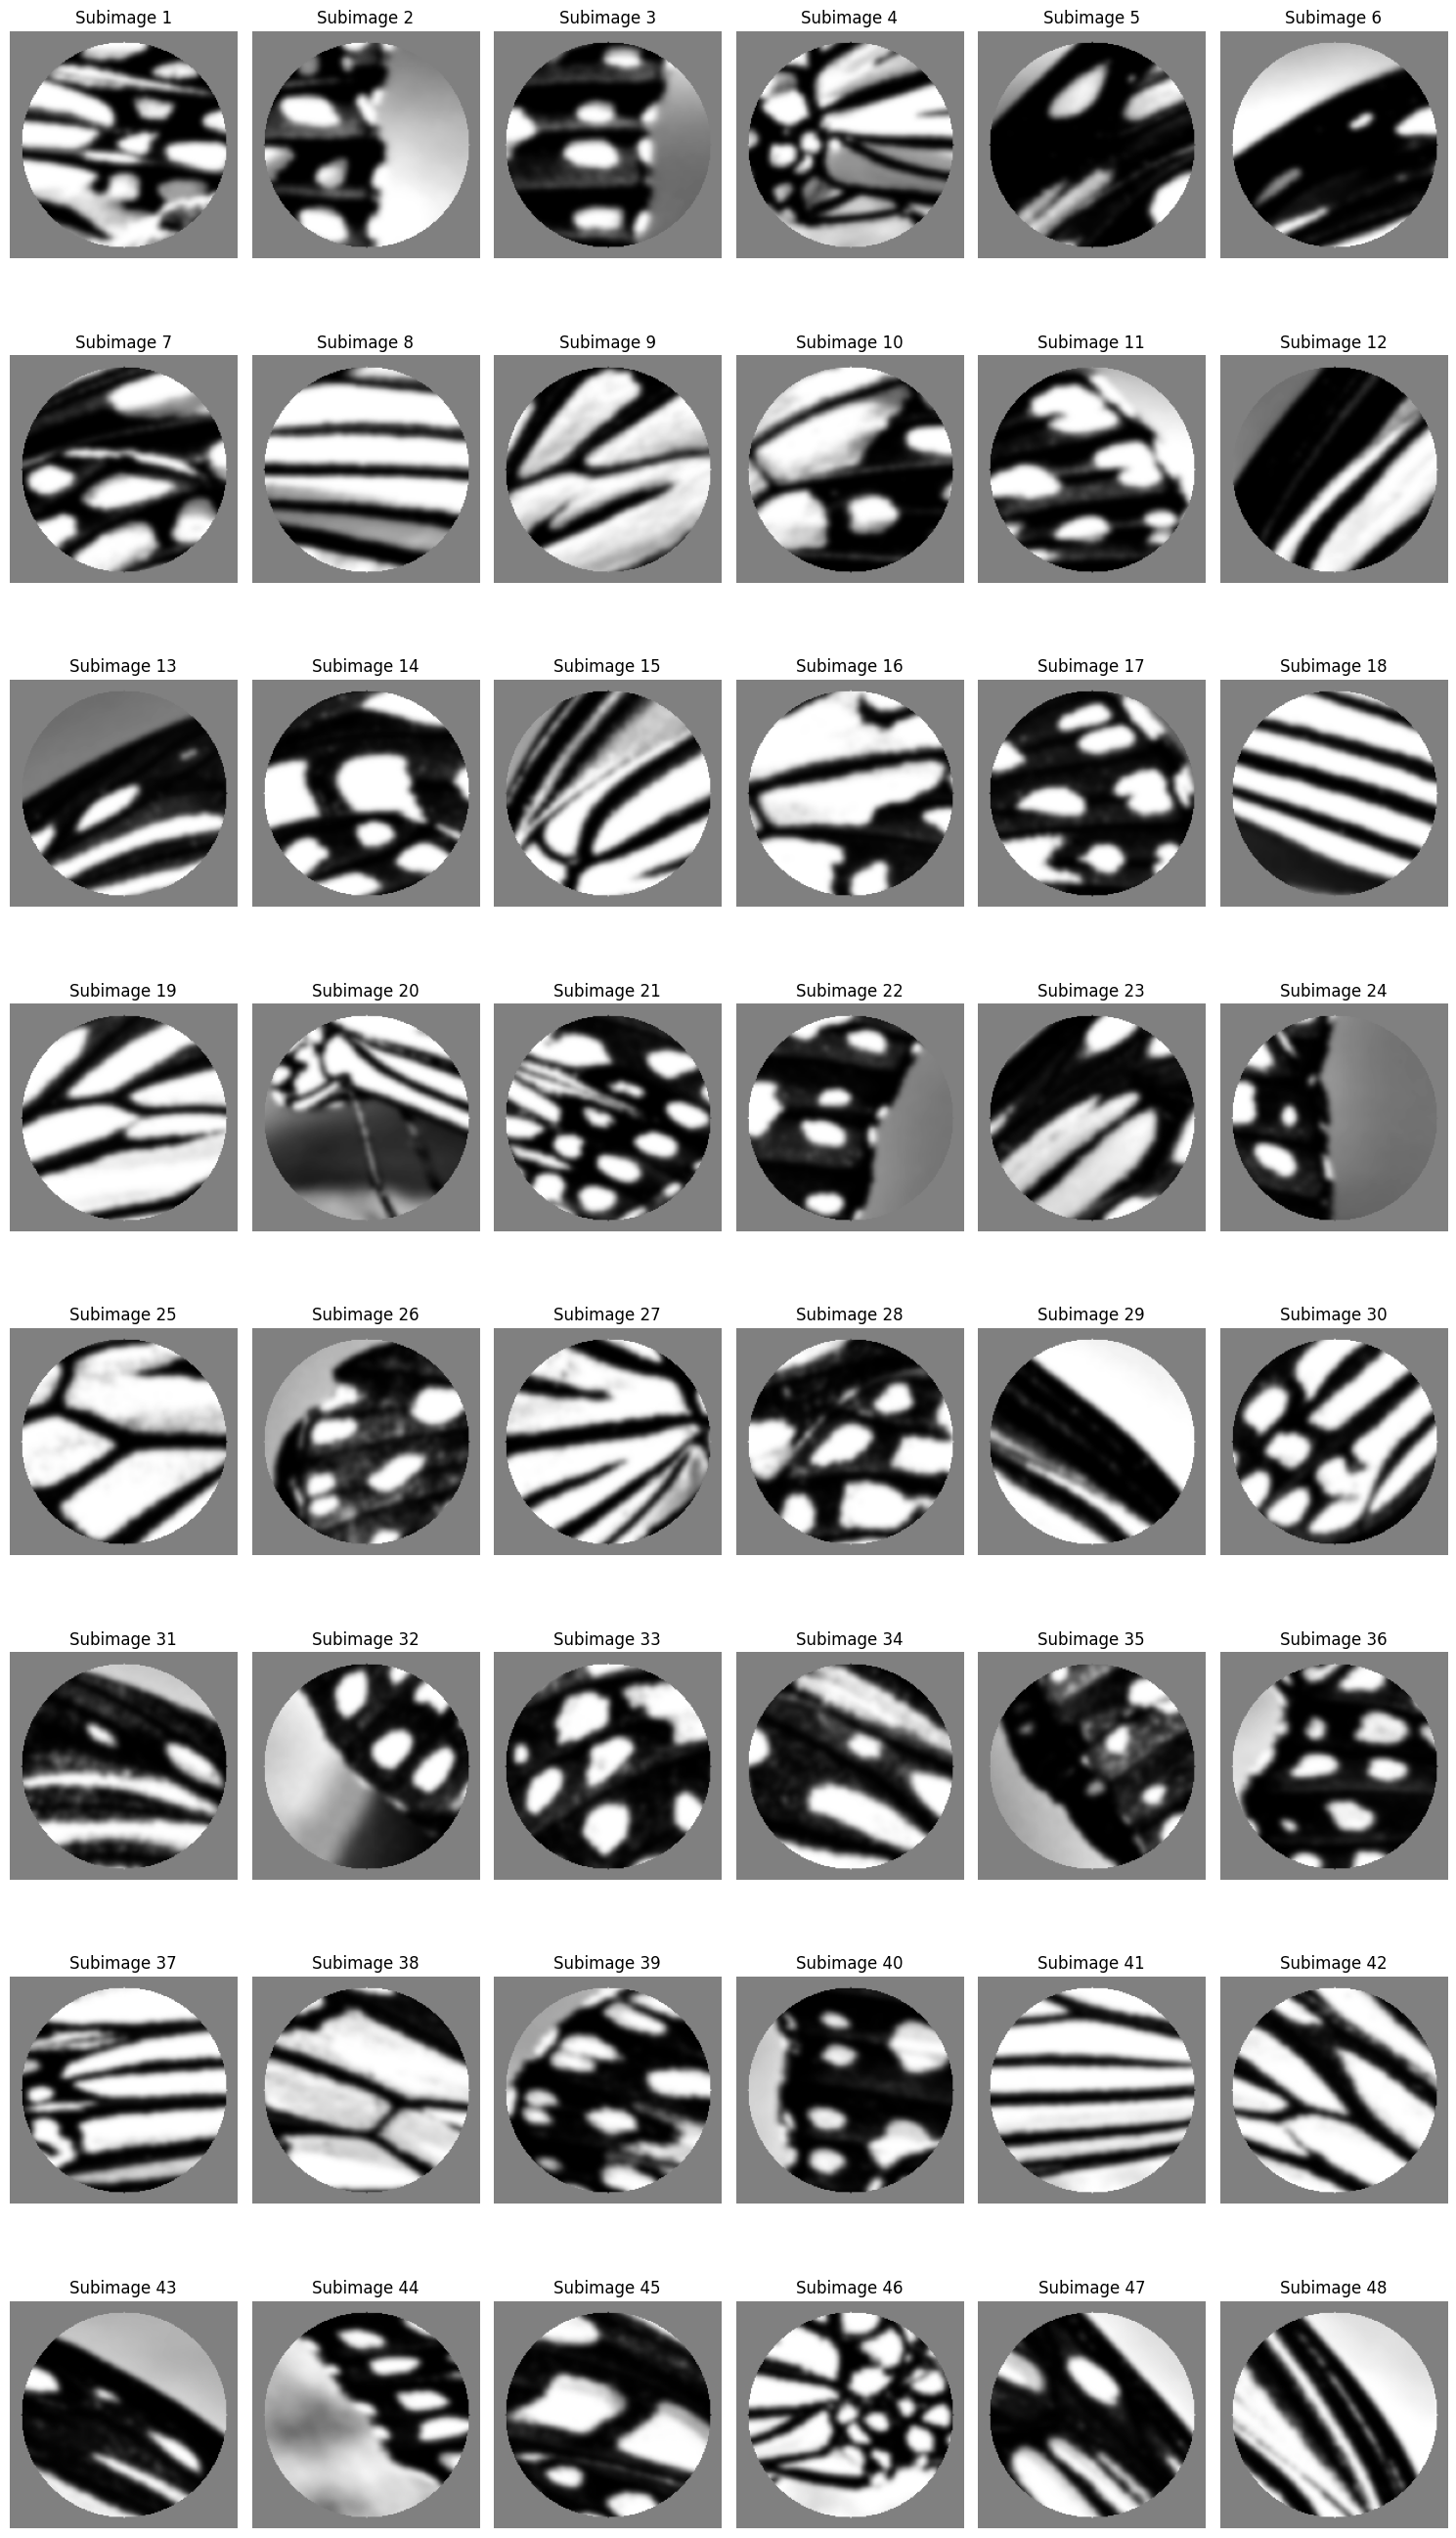

In [59]:
from PIL import Image
import os
import numpy as np

def calculate_entropy(image):
    histogram, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    probabilities = histogram / sum(histogram)
    entropy = -sum(p * np.log2(p) for p in probabilities if p != 0)
    return entropy

def choose_high_entropy_subimage(subimages):
    entropies = [calculate_entropy(np.array(subimage)) for subimage in subimages]
    max_entropy_index = np.argmax(entropies)
    return subimages[max_entropy_index]

def divide_image(image_path, subimage_size):
    original_image = Image.open(image_path)
    width, height = original_image.size

    num_subimages = 16
    subimages = []

    for i in range(0, num_subimages):
        # Calculate the corner coordinates for each subimage
        top_left_x = (i % 4) * subimage_size
        top_left_y = (i // 4) * subimage_size
        bottom_right_x = top_left_x + subimage_size
        bottom_right_y = top_left_y + subimage_size

        # Crop the subimage from the original image
        subimage = original_image.crop((top_left_x, top_left_y, bottom_right_x, bottom_right_y))
        subimages.append(subimage)

    return subimages

# Specify the folder containing images
folder_path = "/content/drive/MyDrive/Colab Notebooks/newDataSet/1"

# List to store high entropy subimages for all images
high_entropy_subimages = []

# Loop through all images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".png"):
        # Construct the full path to the image
        image_path = os.path.join(folder_path, filename)

        # Set the subimage size
        subimage_size = 200

        # Divide the image into subimages
        subimages = divide_image(image_path, subimage_size)

        # Choose the high entropy subimage
        high_entropy_subimage = choose_high_entropy_subimage(subimages)

        # Append the result to the list
        high_entropy_subimages.append(high_entropy_subimage)

# The list high_entropy_subimages now contains the high entropy subimages for all images in the specified folder
# Delete items 7, 11, 27, 28, 29, 34
indices_to_delete = [6, 10, 26, 27, 28, 33]  # Python uses 0-based indexing

for index in sorted(indices_to_delete, reverse=True):
    del high_entropy_subimages[index]

import matplotlib.pyplot as plt

# Set the size of the subplots
fig, axes = plt.subplots(8, 6, figsize=(15, 27))

# Plot all high entropy subimages
for i, (subimage, ax) in enumerate(zip(high_entropy_subimages, axes.flatten())):
    ax.imshow(subimage, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Subimage {i+1}')

plt.tight_layout()
plt.show()

In [60]:
!pip install scikit-fuzzy

<ipython-input-62-8924074f9ad0>:24: RuntimeWarning: divide by zero encountered in log
  magnitude = 20 * np.log(np.abs(f_shift))
<ipython-input-62-8924074f9ad0>:24: RuntimeWarning: divide by zero encountered in log
  magnitude = 20 * np.log(np.abs(f_shift))
<ipython-input-62-8924074f9ad0>:24: RuntimeWarning: divide by zero encountered in log
  magnitude = 20 * np.log(np.abs(f_shift))


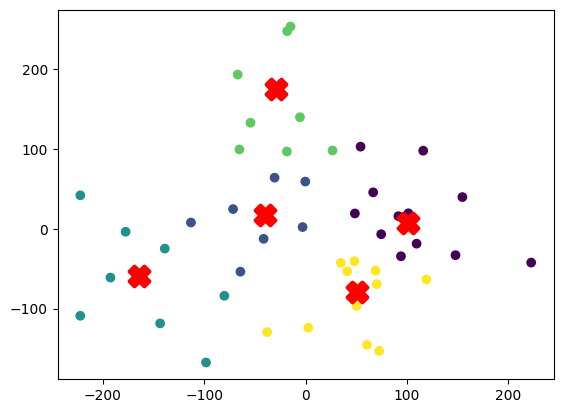

[0.10680422 0.69506486 0.03848829 0.0376042  0.12203843]
[0.52229426 0.14407173 0.04310582 0.16467682 0.12585138]
[0.05894584 0.079698   0.0367673  0.78635262 0.03823624]
[0.55306317 0.19897119 0.03067601 0.05216485 0.16512479]
[0.02863441 0.84795328 0.0547119  0.03522194 0.03347848]
[0.07725328 0.38291596 0.07957739 0.39849346 0.06175991]
[0.973688   0.00772776 0.00202542 0.00377195 0.01278687]
[0.08573431 0.05243419 0.01452922 0.01075938 0.8365429 ]
[0.02335022 0.01449692 0.00651321 0.00385937 0.95178027]
[0.0786027  0.26983924 0.41800423 0.04619874 0.18735508]
[0.72548258 0.07538877 0.0260605  0.05582355 0.11724459]
[0.31862928 0.2236479  0.04897177 0.29862448 0.11012657]
[0.03174177 0.12783736 0.75218909 0.04562301 0.04260876]
[0.9697867  0.00906735 0.00222325 0.00396139 0.01496131]
[0.42175804 0.06935527 0.02768272 0.02823039 0.45297358]
[0.15070352 0.09457174 0.06111556 0.03363999 0.65996918]
[0.10581682 0.12868943 0.0880861  0.03126125 0.6461464 ]
[0.14921445 0.57882778 0.047086

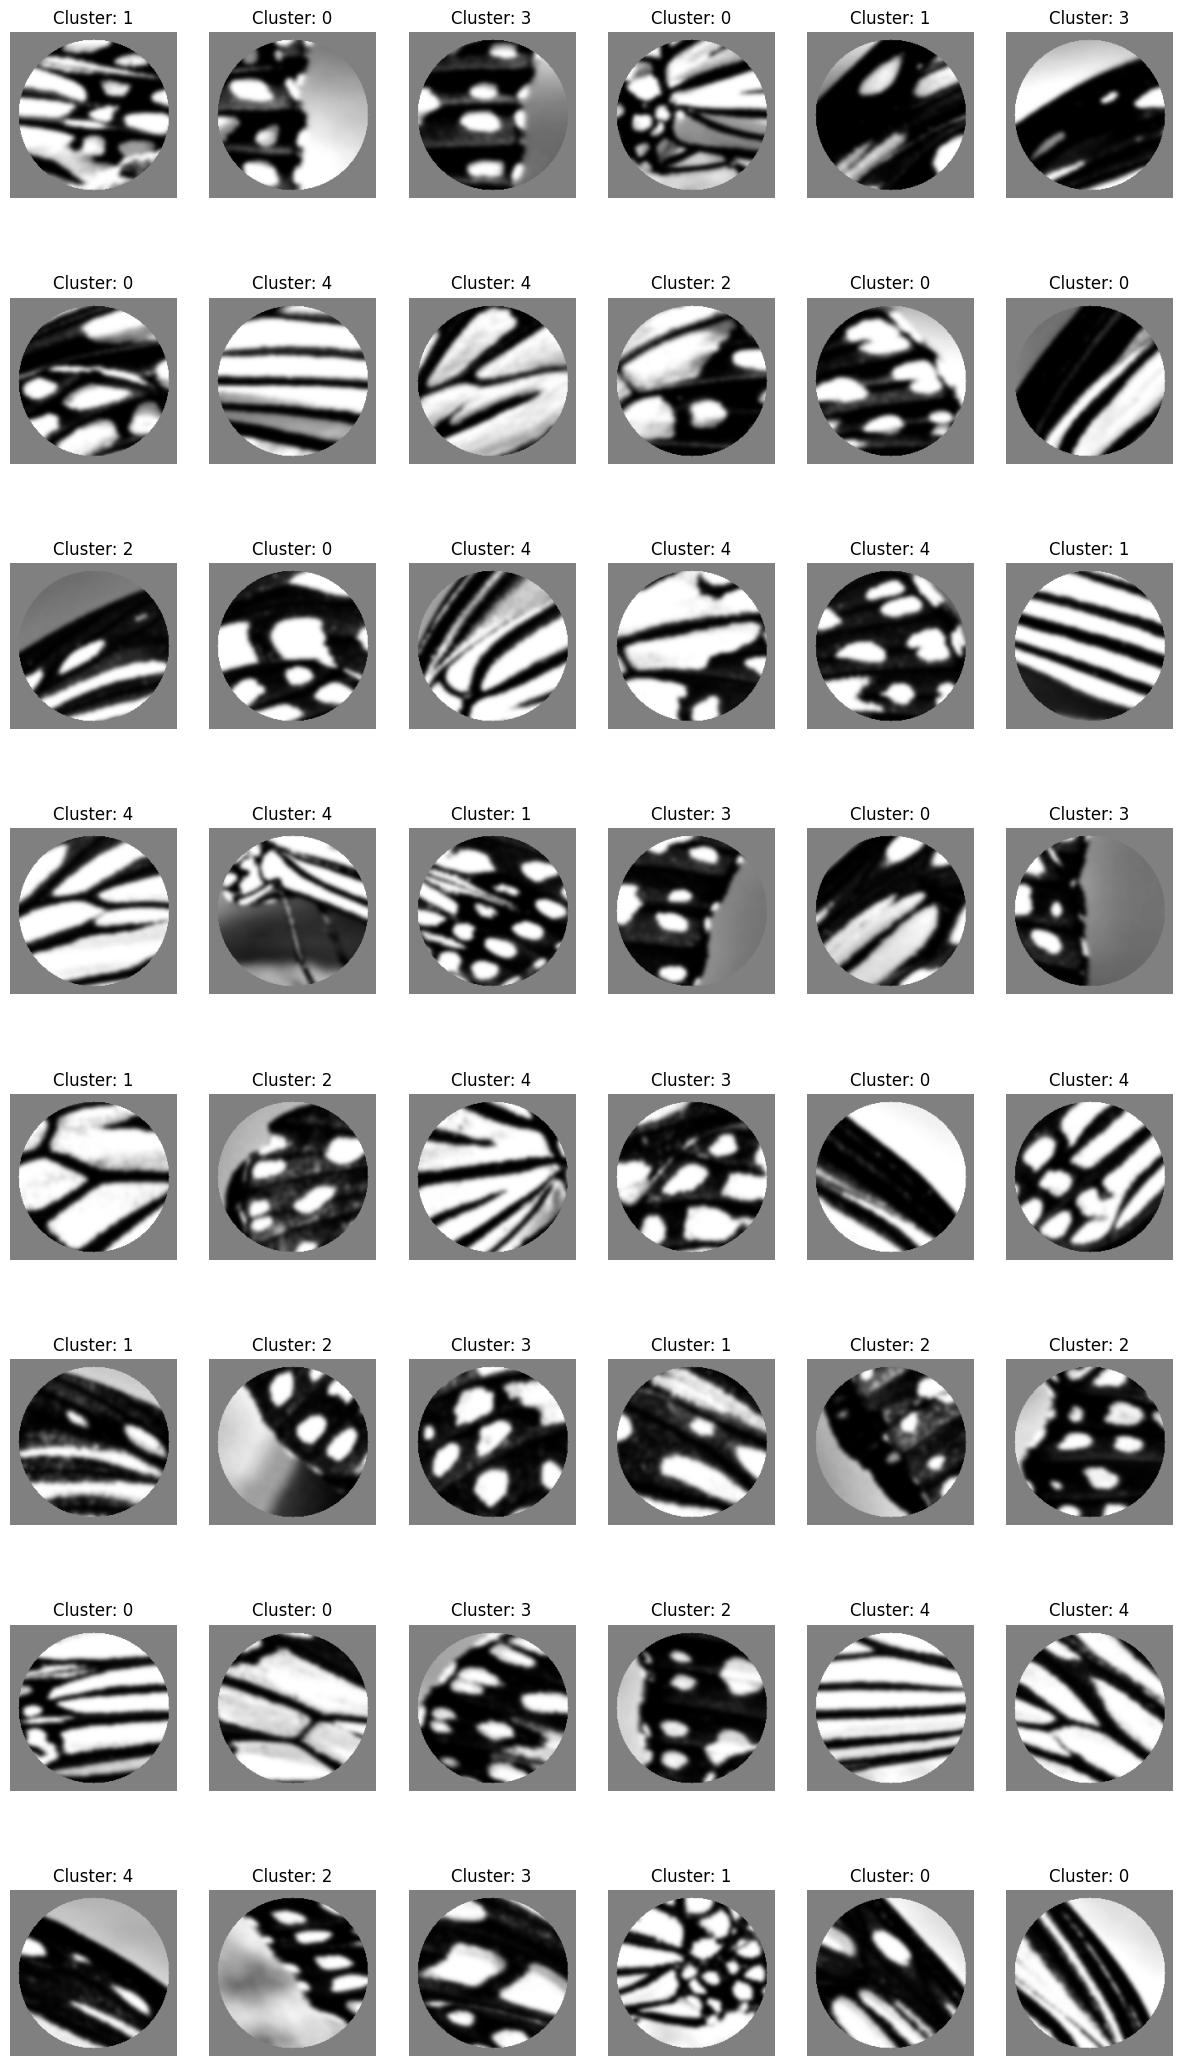

In [62]:
import numpy as np
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2


# Function to extract spatial frequency features using Fourier Transform
def extract_spatial_frequency_features(image):
    # Apply Fourier Transform
    f_transform = np.fft.fft2(image)
    # Shift the zero frequency component to the center
    f_shift = np.fft.fftshift(f_transform)
    # Extract magnitude and phase
    magnitude = 20 * np.log(np.abs(f_shift))
    phase = np.angle(f_shift)
    return magnitude.flatten(), phase.flatten()


# Define Autoencoder architecture
def create_autoencoder(input_dim, encoding_dim):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(input_dim,)))
    model.add(layers.Dense(encoding_dim, activation='relu'))
    model.add(layers.Dense(input_dim, activation='sigmoid'))
    return model


# Function to extract SIFT features
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is not None:
        # Aggregate descriptors, e.g., by taking the mean
        aggregated_descriptors = np.mean(descriptors, axis=0)
    else:
        # Handle case with no descriptors found
        aggregated_descriptors = np.zeros(128)  # SIFT descriptors are 128-dimensional
    return aggregated_descriptors

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
import skfuzzy as fuzz


# Load and preprocess high_entropy_subimages
images = [np.array(subimage) for subimage in high_entropy_subimages]

# Extract spatial frequency features
all_magnitudes = []
all_phases = []
for image in images:
    magnitude, phase = extract_spatial_frequency_features(image)
    all_magnitudes.append(magnitude)
    all_phases.append(phase)
all_sift_features = []
for image in images:
    sift_features = extract_sift_features(image)
    all_sift_features.append(sift_features)

# Combine SIFT features with spatial frequency features
features = np.concatenate([ all_phases, all_sift_features], axis=1)

    # Standardize the extracted features
scaler = StandardScaler()
standardized_features = scaler.fit_transform(features)
# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # Adjust n_components as needed
pca_features = pca.fit_transform(standardized_features)

# Fuzzy k-means clustering
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(pca_features.T, c=5, m=2, error=0.005, maxiter=1000)

# Extracting the cluster membership probabilities
labels = np.argmax(u, axis=0)

# Plotting the results
fig, ax = plt.subplots()
ax.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis')
ax.scatter(cntr[:, 0], cntr[:, 1], marker='X', s=200, linewidths=3, color='r')
plt.show()

for i in range(48):
  print(u[:,i])

# Create a 2x7 figure (adjust the layout based on the number of subimages)
fig, axes = plt.subplots(8, 6, figsize=(15, 27))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Show each subimage in their respective clusters
for i, subimage in enumerate(high_entropy_subimages):
    cluster_label = labels[i]

    axes[i].imshow(subimage, cmap='gray')
    axes[i].set_title(f'Cluster: {cluster_label}')
    axes[i].axis('off')

plt.show()


In [63]:
print(u.shape)
# Calculate the max of each column
max_values = np.max(u, axis=0)

# Find indexes with values less than 0.75
indexes_below_thr = np.where(max_values < 0.6)

# Display the result
print("Max values of each column:", max_values)
print("Indexes with values less than 0.75:", indexes_below_thr)
print("Number of uncertain: ", np.array(indexes_below_thr).shape)

(5, 48)
Max values of each column: [0.69506486 0.52229426 0.78635262 0.55306317 0.84795328 0.39849346
 0.973688   0.8365429  0.95178027 0.41800423 0.72548258 0.31862928
 0.75218909 0.9697867  0.45297358 0.65996918 0.6461464  0.57882778
 0.7005091  0.68462509 0.44148783 0.76443017 0.80151536 0.8864693
 0.83637992 0.51679628 0.4217554  0.34430665 0.48325565 0.99067288
 0.98415386 0.43068655 0.39809074 0.69315167 0.78449887 0.94439841
 0.62814529 0.6530634  0.75140047 0.77259473 0.90267393 0.67545504
 0.75686329 0.75350896 0.80887844 0.45897394 0.86525746 0.65686573]
Indexes with values less than 0.75: (array([ 1,  3,  5,  9, 11, 14, 17, 20, 25, 26, 27, 28, 31, 32, 45]),)
Number of uncertain:  (1, 15)


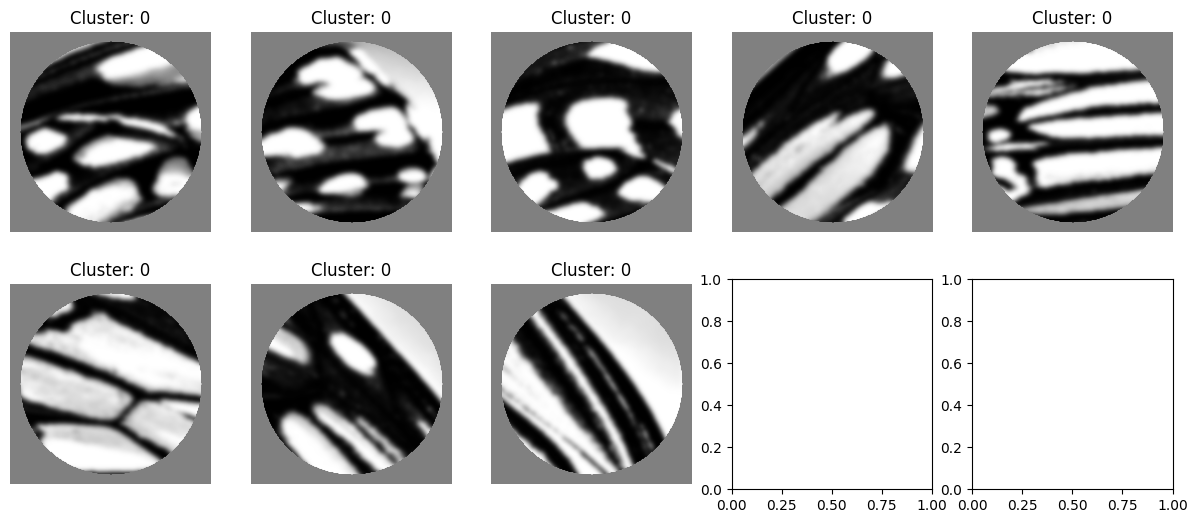

In [64]:
labelsNew = labels
labelsNew[indexes_below_thr] = 9
# Create a 2x7 figure (adjust the layout based on the number of subimages)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Flatten the axes array for easy indexing
axes = axes.flatten()
cnt = 0
# Show each subimage in their respective clusters
for i, subimage in enumerate(high_entropy_subimages):
    cluster_label = labelsNew[i]
    if cluster_label == 0:
        axes[cnt].imshow(subimage, cmap='gray')
        axes[cnt].set_title(f'Cluster: {cluster_label}')
        axes[cnt].axis('off')
        cnt = cnt + 1

plt.show()

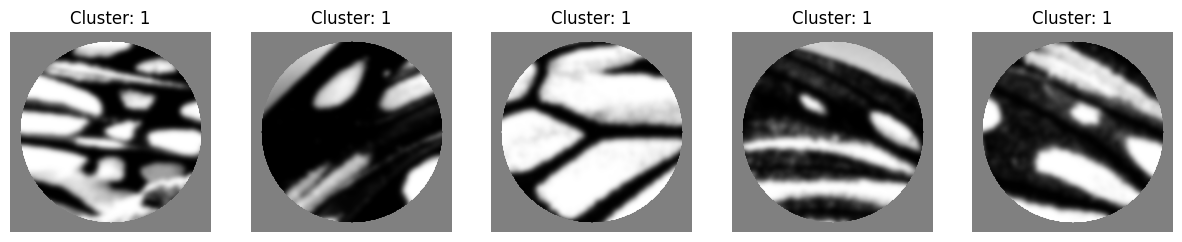

In [66]:
# Create a 2x7 figure (adjust the layout based on the number of subimages)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Flatten the axes array for easy indexing
axes = axes.flatten()
cnt = 0
# Show each subimage in their respective clusters
for i, subimage in enumerate(high_entropy_subimages):
    cluster_label = labelsNew[i]
    if cluster_label == 1:
        axes[cnt].imshow(subimage, cmap='gray')
        axes[cnt].set_title(f'Cluster: {cluster_label}')
        axes[cnt].axis('off')
        cnt = cnt + 1

plt.show()

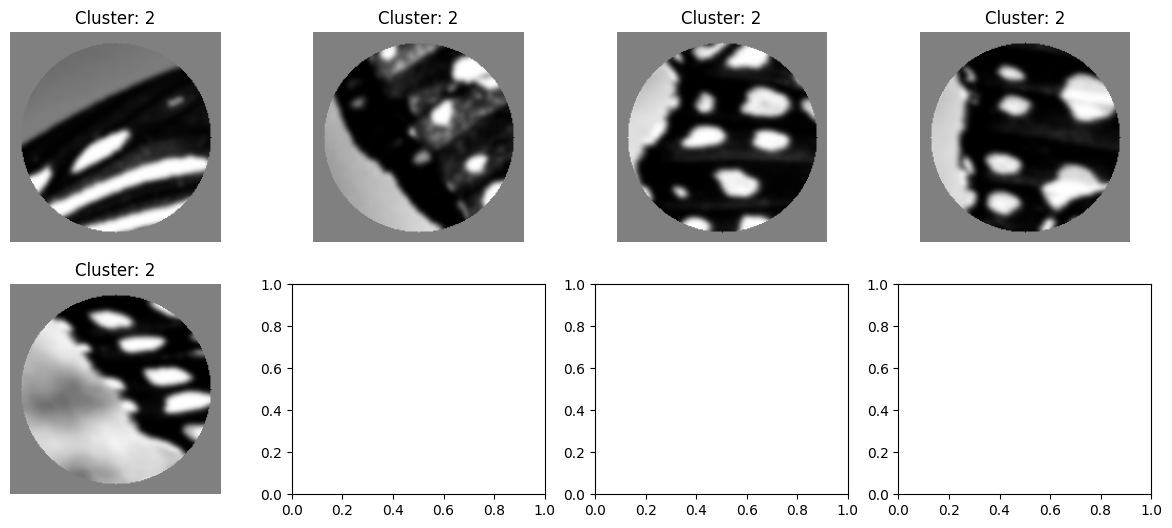

In [67]:
# Create a 2x7 figure (adjust the layout based on the number of subimages)
fig, axes = plt.subplots(2, 4, figsize=(15, 6))

# Flatten the axes array for easy indexing
axes = axes.flatten()
cnt = 0
# Show each subimage in their respective clusters
for i, subimage in enumerate(high_entropy_subimages):
    cluster_label = labelsNew[i]
    if cluster_label == 2:
        axes[cnt].imshow(subimage, cmap='gray')
        axes[cnt].set_title(f'Cluster: {cluster_label}')
        axes[cnt].axis('off')
        cnt = cnt + 1

plt.show()

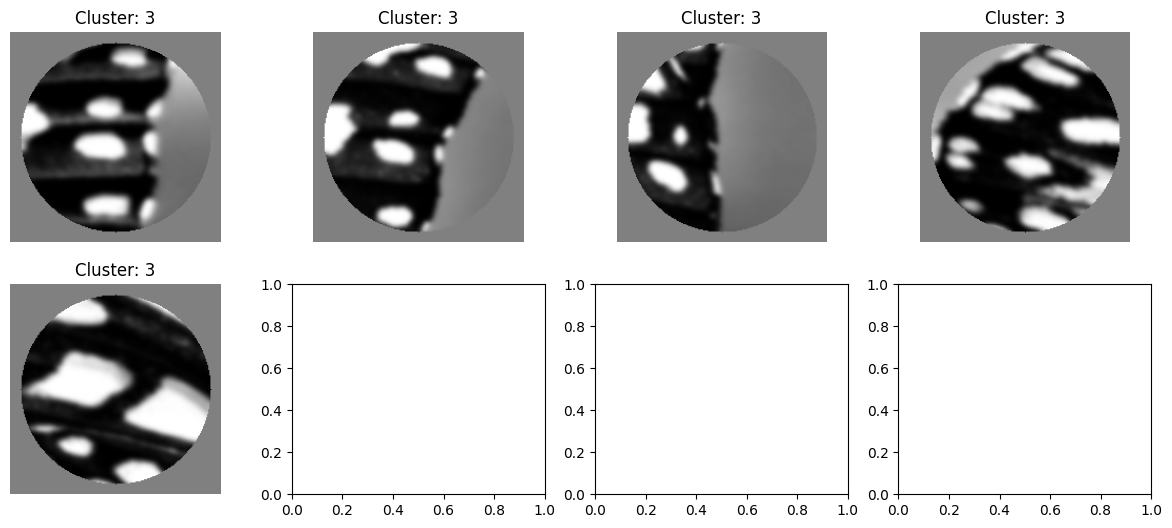

In [68]:
# Create a 2x7 figure (adjust the layout based on the number of subimages)
fig, axes = plt.subplots(2, 4, figsize=(15, 6))

# Flatten the axes array for easy indexing
axes = axes.flatten()
cnt = 0
# Show each subimage in their respective clusters
for i, subimage in enumerate(high_entropy_subimages):
    cluster_label = labelsNew[i]
    if cluster_label == 3:
        axes[cnt].imshow(subimage, cmap='gray')
        axes[cnt].set_title(f'Cluster: {cluster_label}')
        axes[cnt].axis('off')
        cnt = cnt + 1

plt.show()

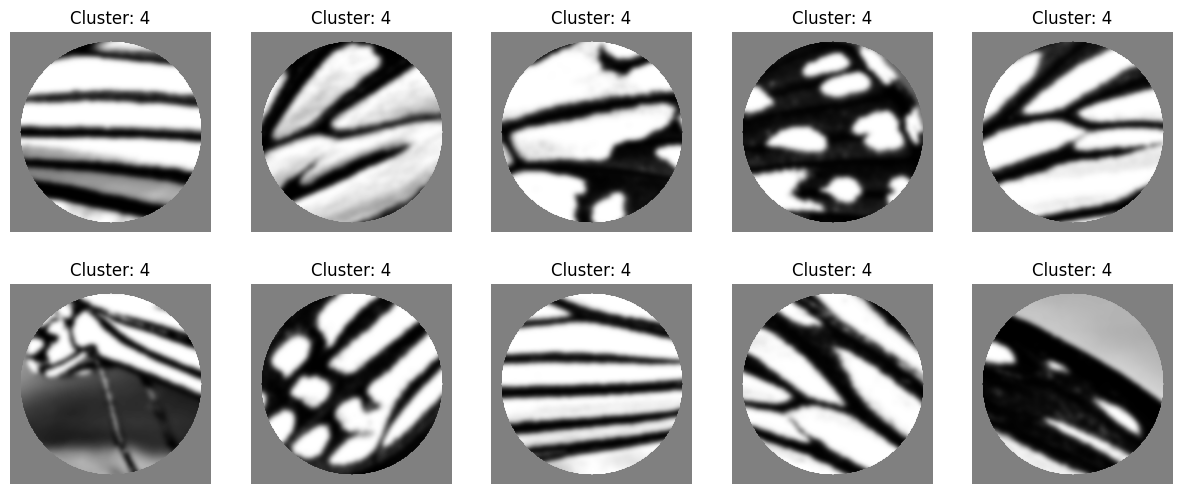

In [70]:
# Create a 2x7 figure (adjust the layout based on the number of subimages)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Flatten the axes array for easy indexing
axes = axes.flatten()
cnt = 0
# Show each subimage in their respective clusters
for i, subimage in enumerate(high_entropy_subimages):
    cluster_label = labelsNew[i]
    if cluster_label == 4:
        axes[cnt].imshow(subimage, cmap='gray')
        axes[cnt].set_title(f'Cluster: {cluster_label}')
        axes[cnt].axis('off')
        cnt = cnt + 1

plt.show()

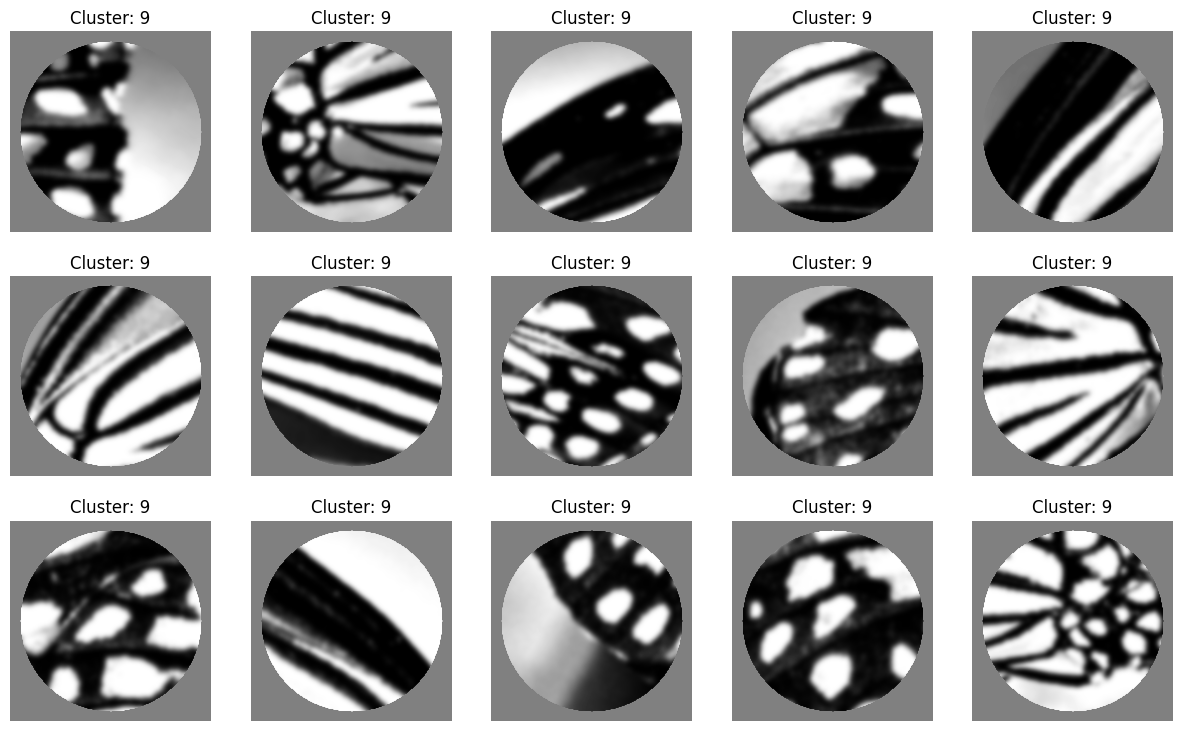

In [71]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# Flatten the axes array for easy indexing
axes = axes.flatten()
cnt = 0
# Show each subimage in their respective clusters
for i, subimage in enumerate(high_entropy_subimages):
    cluster_label = labelsNew[i]
    if cluster_label == 9:
        axes[cnt].imshow(subimage, cmap='gray')
        axes[cnt].set_title(f'Cluster: {cluster_label}')
        axes[cnt].axis('off')
        cnt = cnt + 1

plt.show()